# <h1><center>MPC Planner  <a href="https://colab.research.google.com/github/patsyuk03/thesis_2025/blob/colab_demo/sampling_based_planner/mpc_planning.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="140" align="center"/></a></center></h1>

In [20]:
import numpy as np
from mjx_planner import cem_planner
import mujoco
import time
import jax.numpy as jnp
import matplotlib.pyplot as plt
import mediapy as media

def quaternion_distance(q1, q2):
    dot_product = np.abs(np.dot(q1, q2))
    dot_product = jnp.clip(dot_product, -1.0, 1.0)
    return 2 * np.arccos(dot_product)

def rotation_quaternion(angle_deg, axis):
    axis = axis / np.linalg.norm(axis)
    angle_rad = np.deg2rad(angle_deg)
    w = np.cos(angle_rad / 2)
    x, y, z = axis * np.sin(angle_rad / 2)
    return (round(w, 5), round(x, 5), round(y, 5), round(z, 5))

def quaternion_multiply(q1, q2):
		w1, x1, y1, z1 = q1
		w2, x2, y2, z2 = q2
		
		w = w2 * w1 - x2 * x1 - y2 * y1 - z2 * z1
		x = w2 * x1 + x2 * w1 + y2 * z1 - z2 * y1
		y = w2 * y1 - x2 * z1 + y2 * w1 + z2 * x1
		z = w2 * z1 + x2 * y1 - y2 * x1 + z2 * w1
		
		return (round(w, 5), round(x, 5), round(y, 5), round(z, 5))

In [21]:
start_time = time.time()
cem =  cem_planner(
    num_dof=6, 
    num_batch=4000, 
    num_steps=10, 
    maxiter_cem=2,
    w_pos=5,
    w_rot=1.5,
    w_col=15,
    num_elite=0.05,
    timestep=0.05
    )
print(f"Initialized CEM Planner: {round(time.time()-start_time, 2)}s")


 Default backend: gpu
 Model path: /home/hurova/thesis_2025/sampling_based_planner/ur5e_hande_mjx/scene.xml 
 Timestep: 0.05 
 CEM Iter: 2 
 Number of batches: 4000 
 Number of steps per trajectory: 10 
 Time per trajectory: 0.5
Initialized CEM Planner: 0.14s


In [22]:
model = cem.model
data = cem.data
data.qpos[:6] = jnp.array([1.5, -1.8, 1.75, -1.25, -1.6, 0])
mujoco.mj_forward(model, data)
renderer = mujoco.Renderer(model)

xi_mean = jnp.zeros(cem.nvar)
target_pos = model.body(name="target").pos
target_rot = model.body(name="target").quat

In [23]:
start_time = time.time()
_ = cem.compute_cem(xi_mean, data.qpos[:6], data.qvel[:6], data.qacc[:6], target_pos, target_rot)
print(f"Compute CEM: {round(time.time()-start_time, 2)}s")

Compute CEM: 12.11s


In [24]:
init_position = data.site_xpos[model.site(name="tcp").id].copy()
init_rotation = data.xquat[model.body(name="hande").id].copy()

target_positions = [
    [-0.3, 0.3, 0.8],
    [-0.2, -0.4, 1.0],
    [-0.3, -0.1, 0.8],
    init_position
]

target_rotations = [
    rotation_quaternion(-135, np.array([1,0,0])),
    quaternion_multiply(rotation_quaternion(90, np.array([0,0,1])),rotation_quaternion(135, np.array([1,0,0]))),
    quaternion_multiply(rotation_quaternion(180, np.array([0,0,1])),rotation_quaternion(-90, np.array([0,1,0]))),
    init_rotation
]

target_idx = -1

In [25]:
camera = mujoco.MjvCamera() 
camera.lookat[:] = [0.0, 0.0, 0.0]
camera.distance = 3.0  

scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.sitegroup[:] = False  
scene_option.sitegroup[1] = True 

In [26]:
framerate = 30 

cost_list = list()
cost_g_list = list()
cost_r_list = list()
cost_c_list = list()
thetadot_list = list()
theta_list = list()
frames = list()

prev_target_idx = target_idx
while target_idx == prev_target_idx and target_idx<len(target_positions):
    start_time = time.time()
    target_pos = model.body(name="target").pos
    target_rot = model.body(name="target").quat

    cost, best_cost_g, best_cost_c, best_vels, best_traj, xi_mean = cem.compute_cem(xi_mean, data.qpos[:6], data.qvel[:6], data.qacc[:6], target_pos, target_rot)
    thetadot = np.mean(best_vels[1:5], axis=0)
    # thetadot = best_vels[1]

    data.qvel[:6] = thetadot
    mujoco.mj_step(model, data)

    cost_g = np.linalg.norm(data.site_xpos[cem.tcp_id] - target_pos)   
    cost_r = quaternion_distance(data.xquat[cem.hande_id], target_rot)  
    cost = np.round(cost, 2)
    print(f'Step Time: {"%.0f"%((time.time() - start_time)*1000)}ms | Cost g: {"%.2f"%(float(cost_g))} | Cost r: {"%.2f"%(float(cost_r))} | Cost c: {"%.2f"%(float(best_cost_c))} | Cost: {cost}')

    if len(frames) < data.time * framerate:
        renderer.update_scene(data, scene_option=scene_option, camera=camera)
        pixels = renderer.render()
        frames.append(pixels)

    if cost_g<0.03 and cost_r<0.3:
        target_idx += 1
        if target_idx<len(target_positions):
            model.body(name="target").pos = target_positions[target_idx]
            model.body(name="target").quat = target_rotations[target_idx]

    cost_g_list.append(cost_g)
    cost_r_list.append(cost_r)
    cost_c_list.append(best_cost_c)
    thetadot_list.append(thetadot)
    theta_list.append(data.qpos[:6].copy())
    cost_list.append(cost[-1])

    time_until_next_step = model.opt.timestep - (time.time() - start_time)
    if time_until_next_step > 0:
        time.sleep(time_until_next_step)  

Step Time: 49ms | Cost g: 0.38 | Cost r: 0.28 | Cost c: 0.01 | Cost: [22.26     22.109999]
Step Time: 46ms | Cost g: 0.37 | Cost r: 0.27 | Cost c: 0.01 | Cost: [20.93 20.8 ]
Step Time: 43ms | Cost g: 0.37 | Cost r: 0.25 | Cost c: 0.00 | Cost: [19.63     19.539999]
Step Time: 43ms | Cost g: 0.36 | Cost r: 0.22 | Cost c: 0.00 | Cost: [18.57 18.5 ]
Step Time: 44ms | Cost g: 0.35 | Cost r: 0.19 | Cost c: 0.00 | Cost: [17.57 17.57]
Step Time: 45ms | Cost g: 0.35 | Cost r: 0.16 | Cost c: 0.00 | Cost: [16.91 16.85]
Step Time: 44ms | Cost g: 0.34 | Cost r: 0.14 | Cost c: 0.01 | Cost: [16.27 16.22]
Step Time: 43ms | Cost g: 0.33 | Cost r: 0.11 | Cost c: 0.01 | Cost: [15.559999 15.559999]
Step Time: 43ms | Cost g: 0.32 | Cost r: 0.09 | Cost c: 0.02 | Cost: [15.04 15.04]
Step Time: 43ms | Cost g: 0.31 | Cost r: 0.07 | Cost c: 0.02 | Cost: [14.57 14.57]
Step Time: 43ms | Cost g: 0.30 | Cost r: 0.05 | Cost c: 0.02 | Cost: [14.17 14.16]
Step Time: 43ms | Cost g: 0.29 | Cost r: 0.04 | Cost c: 0.02 | 

In [27]:
media.show_video(frames, fps=framerate)

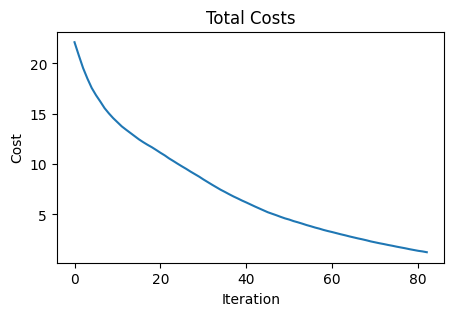

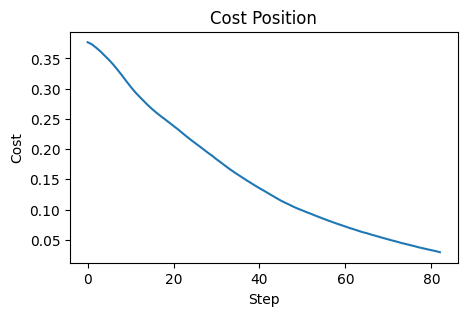

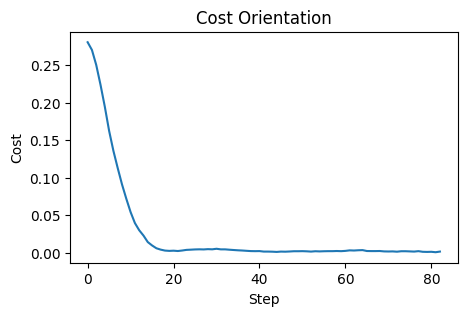

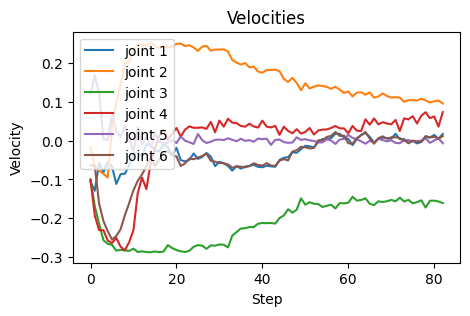

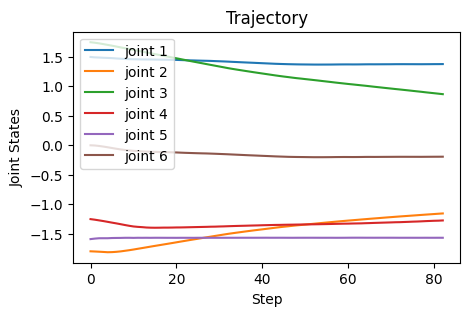

In [28]:

plt.figure(0, figsize=(5, 3))
plt.plot(cost_list)
plt.title("Total Costs")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

plt.figure(0, figsize=(5, 3))
plt.plot(cost_g_list)
plt.title("Cost Position")
plt.xlabel("Step")
plt.ylabel("Cost")
plt.show()

plt.figure(0, figsize=(5, 3))
plt.plot(cost_r_list)
plt.title("Cost Orientation")
plt.xlabel("Step")
plt.ylabel("Cost")
plt.show()

plt.figure(0, figsize=(5, 3))
plt.plot(thetadot_list)
plt.title("Velocities")
plt.xlabel("Step")
plt.ylabel("Velocity")
plt.legend(['joint 1', 'joint 2', 'joint 3', 'joint 4', 'joint 5', 'joint 6'], loc='upper left')
plt.show()

plt.figure(0, figsize=(5, 3))
plt.plot(theta_list)
plt.title("Trajectory")
plt.xlabel("Step")
plt.ylabel("Joint States")
plt.legend(['joint 1', 'joint 2', 'joint 3', 'joint 4', 'joint 5', 'joint 6'], loc='upper left')
plt.show()
